In [1]:
from __future__ import print_function, division, absolute_import
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rc
from scipy.signal import spectrogram

#plt.style.use('dark_background')
rc('font', size=15)
rc('legend', fontsize=10)
rc('xtick', labelsize=12)

fig_size = (12, 5)

In [4]:
from skreflectometry.mode_O import N2_O, refractive_matrix_O, cutoff_freq_O, abel_inversion, CalcInvPerfO
from skreflectometry.mode_X import refraction_index_X, refractive_matrix_X, cutoff_freq_X
from skreflectometry.physics import cyclotron_frequency, plasma_frequency, cyclotron_field, plasma_density, upper_hybrid_frequency, distance_vacuum
#from SimulateGroupDelayDispersive import create_density, create_ne_drop
from skreflectometry.data_generation import density_profile, density_add_bump, magnetic_field_profile
from skreflectometry.reflectometry_sim import phase_delay, group_delay, beat_signal, beat_maximums
from skreflectometry.graphs import (
    plot_refractive_matrix, plot_beat_spectogram, plot_profiles_reconstruction
)

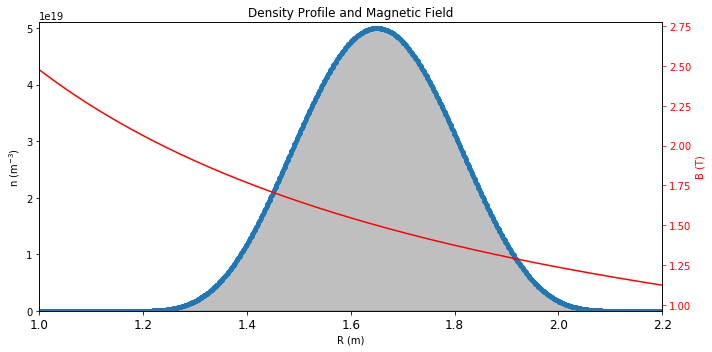

In [5]:
plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
radius_arr, dens_prof = density_profile(n_points=1000)
#dens_prof = density_add_bump(radius_arr, dens_prof, bump_pos=1.5, bump_size=0.2, bump_height=0.5)
# plt.plot(radius_arr, dens_prof, '-o', lw=2)
# plt.fill_between(radius_arr, dens_prof, 0.0, color='k', alpha=0.25)

# plt.xlabel('R (m)')
# plt.ylabel('n (m$^{-3}$)')
# plt.title('Density Profile for O-Mode')

# plt.xlim(1.0, 2.2)
# plt.ylim(0, 5.1e19)

###

# ax1 = plt.subplot(1, 2, 2)
ax1 = plt.gca()
#rs, ns = density_profile(radius_arr=np.linspace(2.15, 2.1, 600), m=30, n=3, dens_central=10e19, r_vacuum=0.002)
rs, ns = density_profile(n_points=1000)
bs = magnetic_field_profile(rs, mag_field_ref=1.5, pos_ref=1.65)
#rs = rs[0] - rs
#ns = density_add_bump(rs, ns, bump_pos=0.02, bump_size=0.001, bump_height=.95*.95)
plt.plot(rs, ns, '-o', markersize=4)
plt.fill_between(rs, ns, 0.0, color='k', alpha=0.25)

plt.xlabel('R (m)')
plt.ylabel('n (m$^{-3}$)')
plt.title('Density Profile and Magnetic Field')

#plt.xlim(0, 0.05)
plt.xlim(1.0, 2.2)
plt.ylim(0, 5.1e19)

ax2 = ax1.twinx()
ax2.plot(rs, bs, 'r-')
ax2.set_ylabel('B (T)', color='r')
ax2.tick_params('y', colors='r')

plt.tight_layout()
#plt.savefig('images/density_profiles.png', dpi=200)
plt.show()

In [161]:
f_sampling = 40.99e6
sweep_time = 25e-6
n_points_fs = int(sweep_time * f_sampling)

fs_O_limits = np.array([1e9, 1e11])
sweep_rate = np.abs(np.diff(fs_O_limits)) / sweep_time

f_sampling_X = 125e6
sweep_time = 25e-6
n_points_fs_X = int(sweep_time * f_sampling_X)
# fs_X_limits = np.array([40e9, 100e9])
fs_X_limits = np.array([1, 100e9])
sweep_rate_X = np.abs(np.diff(fs_X_limits)) / sweep_time

### Calcs ###

#fs_O = np.sort(np.hstack([np.logspace(0, 11, 500), np.linspace(1, 1e11, 500)]))
#Probing frequencies
fs_O = np.linspace(fs_O_limits[0], fs_O_limits[1], n_points_fs)
fs_X = np.linspace(fs_X_limits[0], fs_X_limits[1], n_points_fs_X)
#fs_X = np.linspace(40e9, 100e9, 500)

#n_index_O = refractive_matrix_O(dens_prof, fs_O)
#n_index_X = refractive_matrix_X(ns, fs_X, mag_field=bs)

n_index_O_sq = refractive_matrix_O(dens_prof, fs_O)
n_index_X_sq = refractive_matrix_X(ns, fs_X, mag_field=bs)

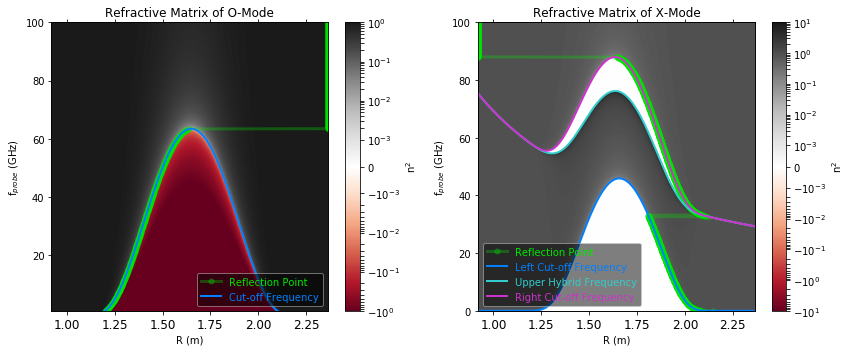

In [162]:
plt.figure(figsize=fig_size)

ax_O = plt.subplot(1, 2, 1)
    
plot_refractive_matrix(radius_arr, dens_prof, fs_O, n_index_O_sq, axis=ax_O, wave_mode='O',
                       antenna_side='hfs', legend_loc='lower right', title='O-Mode')

ax_X = plt.subplot(1, 2, 2)
    
plot_refractive_matrix(rs, ns, fs_X, n_index_X_sq, axis=ax_X, mag_field=bs, wave_mode='X',
                       antenna_side='lfs', legend_loc='lower left', title='X-Mode',
                       norm=colors.SymLogNorm(linthresh=1e-3, clip=True, vmin=-10, vmax=10))

plt.tight_layout()
#plt.savefig('images/refractive_matrixes.png', dpi=200)
plt.show()

In [164]:
n_index_O_sq.shape

(1024, 1000)

(0, 1.2)

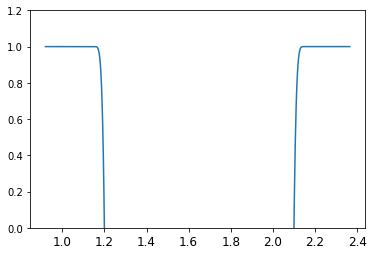

In [165]:
plt.plot(rs, n_index_O_sq[0,:])
#plt.xlim(1.0, 1.5)
plt.ylim(0,1.2)

In [166]:
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.constants import speed_of_light

In [219]:
antenna_side = 'hfs'

reflect_at_wall = True
interp_pts = int(1e5)
phase_delay = np.zeros_like(fs_O)

for ind in range(len(fs_O)):
    if list(n_index_O_sq[ind,:]>=0.0).count(True) == len(rs): #Wave propagates through the plasma
        if reflect_at_wall:
            refract_int = simps(np.sqrt(n_index_O_sq[ind,:]), x=rs)
        else:
            refract_int = np.nan
    else: #There's a reflection layer
        #print('Reflects')
        #Find the non-propagating region
        msk = n_index_O_sq[ind,:]<=0.0
        neg_rad = rs[msk]
        #Finds the first negative index beyond the refraction index pass through zero
        if antenna_side == 'lfs':
            critical_index = np.argmax(rs==np.max(neg_rad)) #Argmax returns the only True
            integ_rad = rs[critical_index:]
            integ_N2 = n_index_O_sq[ind,critical_index:]
            #r_limit = np.max(rs)
            interp_rad = interp1d(integ_N2[0:3], integ_rad[0:3], kind='quadratic')
            zeroth_position = interp_rad(0.0)
            new_rad = np.linspace(zeroth_position, rs[-1], num=interp_pts, endpoint=True)
        else: #hfs
            critical_index = np.argmax(rs==np.min(neg_rad))
            integ_rad = rs[:critical_index+1]
            integ_N2 = n_index_O_sq[ind,:critical_index+1]
            #r_limit = np.min(rs)
            interp_rad = interp1d(integ_N2[-4:], integ_rad[-4:], kind='quadratic')
            zeroth_position = interp_rad(0.0)
            new_rad = np.linspace(rs[0], zeroth_position, num=interp_pts, endpoint=True)
                
        #interp_rad = interp1d(integ_N2[0:3], integ_rad[0:3], kind='quadratic')
        #zeroth_position = interp_rad(0.0)
        #new_rad = np.linspace(zeroth_position, r_limit, num=interp_pts, endpoint=True)
        interp_N2 = interp1d(integ_rad, integ_N2, kind='quadratic', fill_value=0.0)
        new_N2 = interp_N2(new_rad)
        #Rude approximation
        new_N2[0] = 0.0
        refract_int = simps(np.sqrt(new_N2), x=new_rad)
    
    phase_diff = 2 * 2 * np.pi * fs_O[ind] / speed_of_light * refract_int
    phase_diff -= np.pi / 2
    
    phase_delay[ind] = phase_diff

In [208]:
integ_N2[-4:]

array([ 0.30916431,  0.20031284,  0.07856587, -0.05711696])

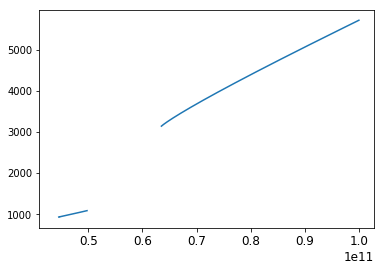

In [220]:
plt.plot(fs_O, phase_delay)
plt.show()

In [120]:
n_index_O_sq[ind,critical_index]

1.0

(0, 300)

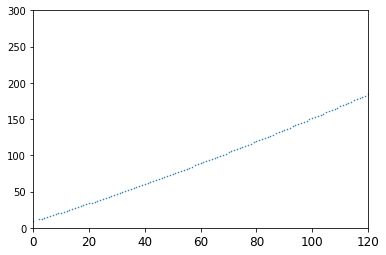

In [218]:
plt.scatter(range(len(phase_delay)), phase_delay, s=0.3)
plt.xlim(0,120)
plt.ylim(0,300)

In [99]:
integ_N2

array([-4.11597275e+01, -4.11709680e+01, -4.11786808e+01, -4.11828643e+01,
       -4.11835179e+01, -4.11806412e+01, -4.11742349e+01, -4.11643003e+01,
       -4.11508394e+01, -4.11338549e+01, -4.11133501e+01, -4.10893292e+01,
       -4.10617971e+01, -4.10307592e+01, -4.09962218e+01, -4.09581919e+01,
       -4.09166769e+01, -4.08716854e+01, -4.08232262e+01, -4.07713091e+01,
       -4.07159446e+01, -4.06571437e+01, -4.05949182e+01, -4.05292806e+01,
       -4.04602439e+01, -4.03878221e+01, -4.03120296e+01, -4.02328816e+01,
       -4.01503939e+01, -4.00645830e+01, -3.99754661e+01, -3.98830609e+01,
       -3.97873859e+01, -3.96884601e+01, -3.95863033e+01, -3.94809359e+01,
       -3.93723789e+01, -3.92606538e+01, -3.91457830e+01, -3.90277891e+01,
       -3.89066958e+01, -3.87825270e+01, -3.86553074e+01, -3.85250623e+01,
       -3.83918174e+01, -3.82555991e+01, -3.81164344e+01, -3.79743508e+01,
       -3.78293765e+01, -3.76815399e+01, -3.75308704e+01, -3.73773975e+01,
       -3.72211516e+01, -

In [73]:
phase_diff

nan

In [81]:
rs[980:]

array([2.33751752, 2.33896396, 2.34041041, 2.34185686, 2.3433033 ,
       2.34474975, 2.3461962 , 2.34764264, 2.34908909, 2.35053554,
       2.35198198, 2.35342843, 2.35487487, 2.35632132, 2.35776777,
       2.35921421, 2.36066066, 2.36210711, 2.36355355, 2.365     ])

In [38]:
np.max(rs[~msk[100]])

2.0120670670670675

In [32]:
#prof_interp = interp1d(n_index_O_sq[100,:], rs, kind='cubic')

#prof_interp([0,0])

array([], shape=(0, 1), dtype=int64)

In [ ]:
if antenna_side.lower() == 'hfs':
    pass    
elif antenna_side.lower() == 'lfs':
    refractive_mat = refractive_mat[:, ::-1]
else:
    raise ValueError('Unknown antenna_side option: '+str(antena_side))
        

In [ ]:
    
    # Returns the index of the first position where refraction < epsilon for
    #   every sampling frequency. If there is no such point, it returns 0.
    
    
    
reflect_pos_ind = np.argmax(refractive_mat <= refract_epsilon, axis=1)

# Find if reflect_pos_ind == 0 are real reflections at entrance (pos = 0)
#   or no reflection in the plasma.
reflect_at_0_ind = (refractive_mat[:, 0] <= refract_epsilon)
reflect_at_0_measured_ind = (reflect_pos_ind == 0)
reflect_at_0_fake_ind = reflect_at_0_ind ^ reflect_at_0_measured_ind

## if reflect_at_wall:  # TODO
##     reflect_pos_ind[reflect_at_0_fake_ind] = -1
## else:
##     reflect_pos_ind[reflect_at_0_fake_ind] = 0

refract_mat_temp = np.copy(refractive_mat)
for freq_ind in range(len(freq_probing)):
    refract_mat_temp[freq_ind, reflect_pos_ind[freq_ind]:-1] = 0

refract_int = np.(refract_mat_temp, radius_arr, axis=1)

phase_diff = 2 * 2 * np.pi * freq_probing / speed_of_light * refract_int
phase_diff -= np.pi / 2

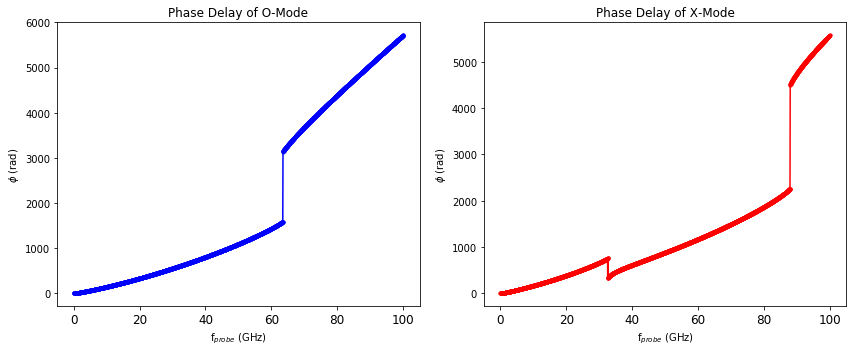

In [10]:
phi_O = phase_delay(fs_O, radius_arr, n_index_O, reflect_at_wall=True)
phi_X = phase_delay(fs_X, rs, n_index_X, refract_epsilon=1e-6, antenna_side='lfs')

plt.figure(figsize=fig_size)

plt.subplot(1, 2, 1)

plt.plot(fs_O/1e9, phi_O, 'b.-')

plt.title('Phase Delay of O-Mode')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel('$\phi$ (rad)')

plt.subplot(1, 2, 2)

plt.plot(fs_X/1e9, phi_X, 'r.-')

plt.title('Phase Delay of X-Mode')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel('$\phi$ (rad)')

plt.tight_layout()
#plt.savefig('images/phase_delays.png', dpi=200)
plt.show()

(0, 2)

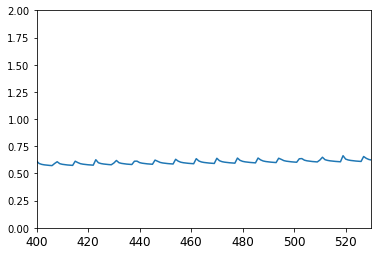

In [11]:
plt.plot(np.diff(phi_O))
plt.xlim(400,530)
plt.ylim(0,2)

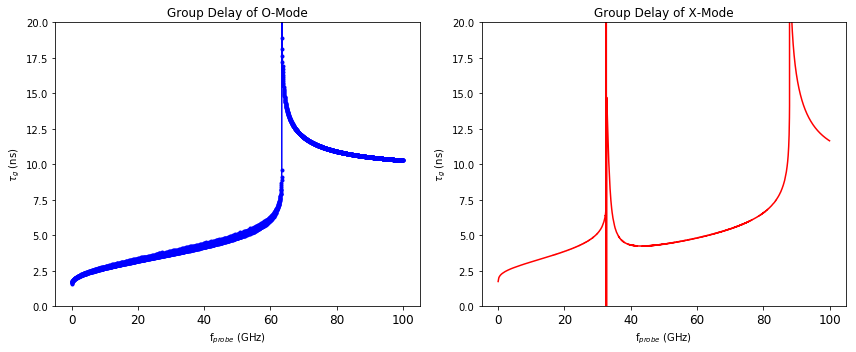

In [12]:
delta_t_O = group_delay(fs_O, phi_O)
delta_t_X = group_delay(fs_X, phi_X)

plt.figure(figsize=fig_size)

plt.subplot(1, 2, 1)

plt.plot(fs_O/1e9, delta_t_O*1e9, 'b.-')

plt.title('Group Delay of O-Mode')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel(r'$\tau_g$ (ns)')

plt.ylim(0, 20)

plt.subplot(1, 2, 2)

plt.plot(fs_X/1e9, delta_t_X*1e9, 'r-')

plt.title('Group Delay of X-Mode')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel(r'$\tau_g$ (ns)')

plt.ylim(0, 20)

plt.tight_layout()
#plt.savefig('images/group_delays.png', dpi=200)
plt.show()

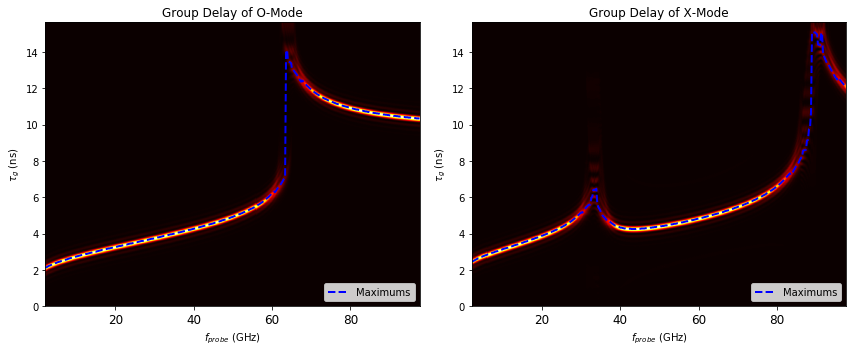

In [9]:
beat_sig = beat_signal(fs_O, delta_t_O)
beat_sig_X = beat_signal(fs_X, delta_t_X)

fs, ts, spectrum = spectrogram(beat_sig, fs=f_sampling, nperseg=136, nfft=2048, noverlap=128)
beat_max = beat_maximums(fs, spectrum)

fsamp_X, ts_X, spectrum_X = spectrogram(beat_sig_X, fs=f_sampling_X, nperseg=128+64, nfft=2048, noverlap=128)
beat_max_X = beat_maximums(fsamp_X, spectrum_X)

delta_t_noise = beat_max / sweep_rate
fs_noise = ts * sweep_rate

plt.figure(figsize=fig_size)

plt.subplot(1, 2, 1)

plot_beat_spectogram(f_sampling, beat_sig, sweep_rate, title='O-Mode')

plt.subplot(1, 2, 2)

plot_beat_spectogram(f_sampling_X, beat_sig_X, sweep_rate_X, title='X-Mode')

plt.tight_layout()
#plt.savefig('images/spectrogram.png', dpi=200)
plt.show()

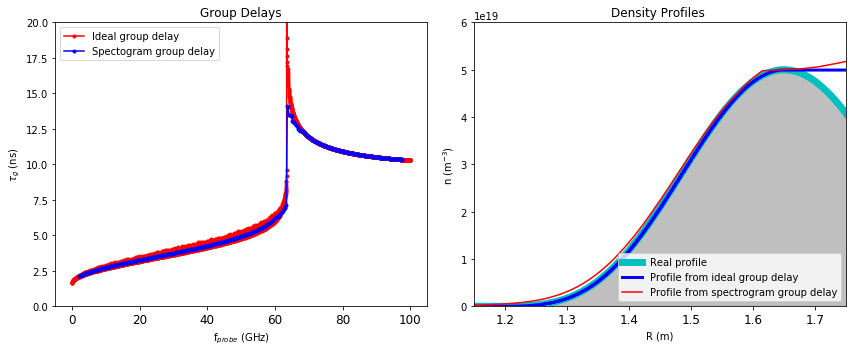

In [10]:
radius_calc, dens_arr_to_calc = abel_inversion(fs_O, delta_t_O, pos_antenna=radius_arr[0]+.015, other_method=False)
radius_calc_other, dens_arr_to_calc_other = abel_inversion(fs_O, delta_t_O, pos_antenna=radius_arr[0], other_method=True)
radius_noise, dens_noise = abel_inversion(fs_noise, delta_t_noise, pos_antenna=radius_arr[0], other_method=True)

plt.figure(figsize=fig_size)

plt.subplot(1, 2, 1)

plt.plot(fs_O*1e-9, delta_t_O*1e9, 'r.-', label='Ideal group delay')
plt.plot(fs_noise*1e-9, delta_t_noise*1e9, 'b.-', label='Spectogram group delay')

plt.title('Group Delays')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel(r'$\tau_g$ (ns)')

plt.ylim(0, 20)

plt.legend(loc='upper left')

plt.subplot(1, 2, 2)

plot_profiles_reconstruction(radius_arr, dens_prof, radius_calc_other, dens_arr_to_calc_other,
                             radius_noise, dens_noise, xlims=(1.15, 1.75), ylims=(0, 6e19), title='')

plt.tight_layout()
#plt.savefig('images/reconstruction.png', dpi=200)
plt.show()